In [1]:
import pandas as pd
from pandas import DataFrame as DF, Series

import numpy as np

import scipy.stats as st

import matplotlib.pyplot as plt
%matplotlib inline

## Multivariate Approach

This data contains two metrics for a particular server. Anomalous behavior can be an indication of various types of problems. The goal is to create a system that can handle a live feed of data to detect anomalies.

1. Check that the training data is suitable for a multivariate modeling approach
    - i.e. check that the data appears to be from a multivariate gaussian distribution
    - you don't need to get too fancy with tests here
2. Check for any drift in the training data mean and std over time
    - if there is drift, determine what span of time (window) should used for modeling incoming data
3. Create the following functions
    - on that returns an estimated multivariate normal distribution for a given window of data
    - another that determines if a single observation is an outlier and takes these params:
        - a single observation
        - the estimated distribution object
        - probability threshold: below which observation is outlier
4. Create a function to simulate a live feed (a stream) of the test data
    - returns a boolean list indicating if each observation was an outlier
    - computes these one-by-one as they come in through simulated feed
    - each observation should be based on last N observations
        - N is the windows size determined in (2)
    - use the last N observations in the test data as a starting point
    - use a threshold of 0.0001
5. Create a single plot that has
    - scatter plot of the test data highlighting detected outliers
    - contour plot overlaid showing how the distribution pdf varies
6. How do you think the threshold could be optimized?

In [2]:
# read data
data_tr = pd.read_csv('multivariate_tr.csv')
data = pd.read_csv('multivariate_ts.csv')

### 1. Check that the training data is suitable for a multivariate modeling approach
- i.e. check that the data appears to be from a multivariate gaussian distribution
- you don't need to get too fancy with tests here

In [3]:
data_tr.describe()

,X1,X2
count,5000.000000,5000.000000
mean,5.355991,2.245740
std,1.856961,1.058475
min,-1.232979,-1.003655
25%,4.125419,1.523453
50%,5.353521,2.150443
75%,6.598291,2.849264
max,13.317971,8.477483


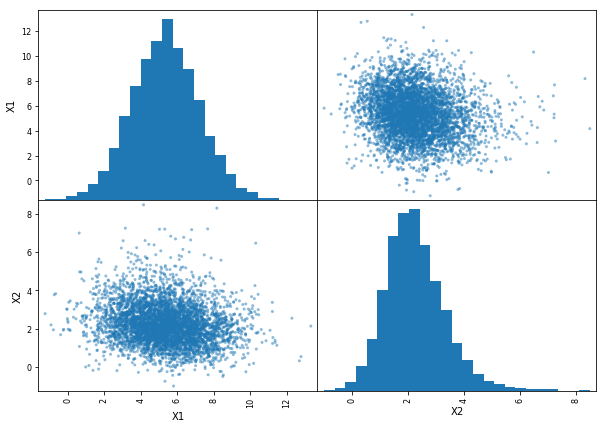

In [4]:
from pandas.plotting import scatter_matrix

scatter_matrix(data_tr, hist_kwds={'bins':25}, figsize=(10,7));

### 2. Check for any drift in the training data mean and std over time
- if there is drift, determine what span of time (window) should used for modeling incoming data

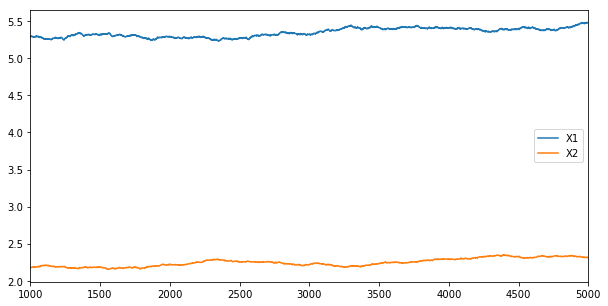

In [5]:
data_tr.rolling(window=1000).mean().dropna().plot(figsize=(10,5));

### 3. Create the following functions
- on that returns an estimated multivariate normal distribution for a given window of data
- another that determines if a single observation is an outlier and takes these params:
    - a single observation
    - the estimated distribution object
    - probability threshold: below which observation is outlier

In [6]:
# estimate and return multivariate gaussian distribution
def multi_gaus_dist(window):
    means = window.mean()
    cov = window.cov()
    dist = st.multivariate_normal(means, cov)
    return dist

# check if obs is outlier
def isoutlier(obs, dist, thresh=0.0001):
    p = dist.pdf(obs)
    if p < thresh:
        return True
    else:
        return False

In [7]:
dist = multi_gaus_dist(data_tr)
sum([isoutlier(point[1:], dist) for point in data.itertuples()])

178

### 4. Create a function to simulate a live feed (a stream) of the test data
- returns a boolean list indicating if each observation was an outlier
- computes these one-by-one as they come in through simulated feed
- each observation should be based on last N observations
    - N is the windows size determined in (2)
- use the last N observations in the test data as a starting point
- use a threshold of 0.0001

In [8]:
combined_df = pd.concat([data_tr.iloc[-1000:], data], axis=0)

In [9]:
anomaly = []
for i in range(1000, len(combined_df)):
    window = combined_df.iloc[i-1000:i]
    dist = multi_gaus_dist(window)
    obs = combined_df.iloc[i]
    anomaly.append(isoutlier(obs, dist, thresh=0.00001))

In [10]:
outliers = data[anomaly]
inliers = data[~np.array(anomaly)]

In [11]:
outliers.shape, inliers.shape

((60, 2), (25348, 2))

### 5. Create a single plot that has
- scatter plot of the test data highlighting detected outliers
- contour plot overlaid showing how the distribution pdf varies

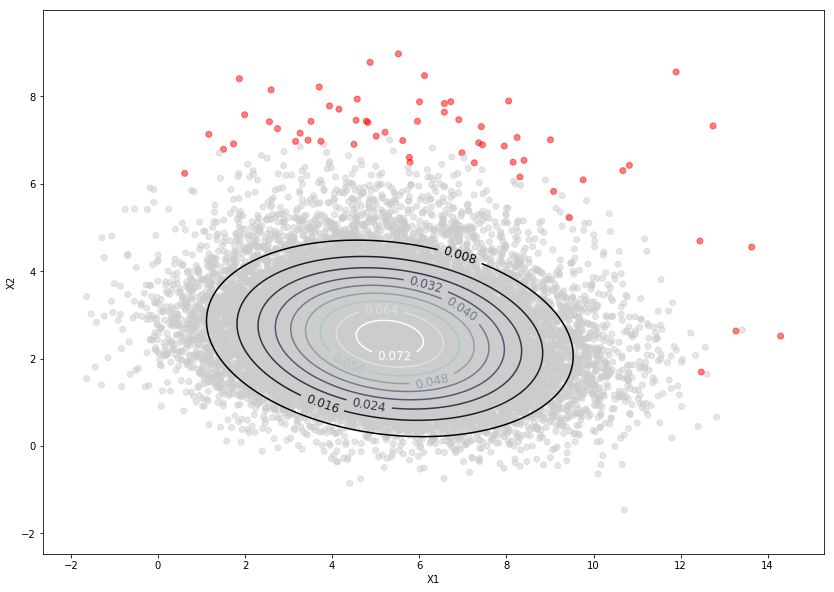

In [12]:
mu = data.mean()
cov = data.cov()
mvd = st.multivariate_normal(mu, cov)
mesh = np.mgrid[data.X1.min()-1:data.X1.max()+1:.01, 
               data.X2.min()-1:data.X2.max()+1:.01]
pos = np.empty(mesh[0].shape + (2,))
pos[:, :, 0] = mesh[0]
pos[:, :, 1] = mesh[1]

plt.figure(figsize=(14,10))
ax = plt.contour(mesh[0], mesh[1], mvd.pdf(pos), 10, cmap='bone')
plt.clabel(ax, inline=1, fontsize=12)

temp = data.copy()
temp['anomaly'] = anomaly
temp.loc[:, 'anomaly'] = temp.anomaly.map({True:'red', False:'#cccccc'})
plt.scatter(temp['X1'], temp['X2'], c=temp['anomaly'], alpha=0.5)
plt.xlabel('X1')
plt.ylabel('X2');

### 6. How do you think the threshold could be optimized?

One way to optimize the threshold would be to use historical data to label observations that, in hindsight, qualify as anomalies. With these labels you can use CV to tune the threshold until you get the best value on some metric (e.g. F1-score).

## Detect Anomalous Number Of Defects

This dataset contains chronological data for a computer system. The data simply indicates if an error ocurred at a given time with a 1, otherwise a 0 is output. This system has a fixed expectation value of 5 errors per thousand. The goal is to detect if there were an abnormal number of errors for any given time-window.

1. Given the description and goal, what distribution should be used to model this data?
2. Create a script that will simulate this data as a feed
    - number of defects will only be analyzed every 1000 observations
    - each 1000 will count as one block
    - each of these blocks will be classified as anomalous or not (as a whole)
    - use a threshold of 0.01
3. Create a plot with the following properties
    - x-axis: block number
    - y-axis: number of errors in the block
    - highlight blocks labeld as anomalies

In [13]:
data = np.loadtxt('errors.csv')
data

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

### 1. Given the description and goal, what distribution should be used to model this data?

Poisson Distribution.

### 2. Create a script that will simulate this data as a feed and label anomalies
- number of errors will only be analyzed every 1000 observations
- each 1000 will count as one block
- each of these blocks will be classified as anomalous or not (as a whole)
- use a threshold of 0.01

In [14]:
1e3*data.mean(), data.reshape(1000,-1).sum(axis=0).mean()

(4.8842794759825328, 4.8842794759825328)

In [15]:
anomalies = []
fullset = []
thresh = 0.01
mu = 1e3*data.mean()
rv = st.poisson(mu=mu)
n = 0
for i,v in enumerate(data):
    if i%1e3 == 0:
        p = rv.pmf(n)
        fullset.append((i//1e3, n))
        if p < thresh:
            anomalies.append((i//1e3, n, p))
        n = 0
    if v == 1:
        n += 1
print('Stream Complete')

Stream Complete


In [16]:
anomalies = DF(anomalies, columns=['block','n_errors','p-value']).astype({'block': int})
fullset = DF(fullset, columns=['block','n_errors']).astype({'block': int})

In [17]:
anomalies

,block,n_errors,p-value
0,0,0,0.007565
1,59,13,0.001094
2,122,11,0.007152
3,179,0,0.007565
4,343,0,0.007565
5,373,11,0.007152
6,386,11,0.007152


In [18]:
fullset.head()

,block,n_errors
0,0,0
1,1,7
2,2,7
3,3,5
4,4,8


### 3. Create a plot with the following properties
- x-axis: block number
- y-axis: number of errors in the block
- highlight blocks labeld as anomalies

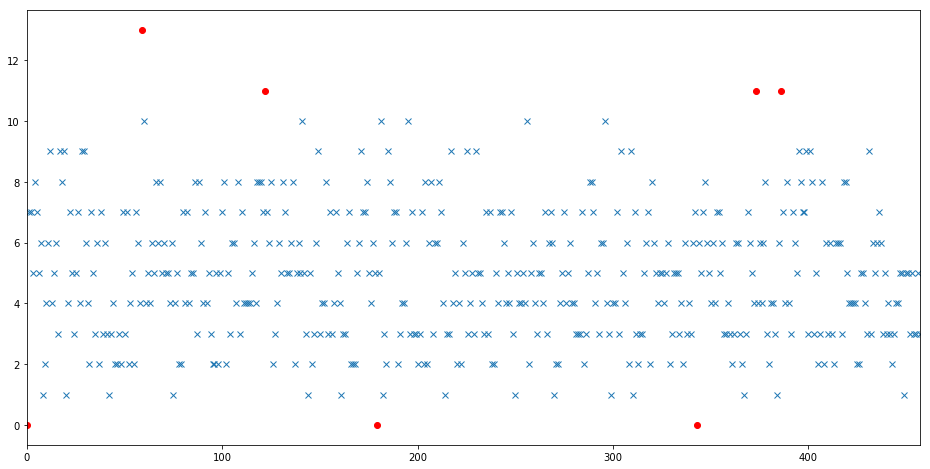

In [19]:
# fullset.n_errors.plot(figsize=(16,8), style='o')
outliers = fullset[fullset.block.isin(anomalies.block)].n_errors
inliers = fullset[~fullset.index.isin(anomalies.block)].n_errors

outliers.plot(figsize=(16,8), style='ro')
inliers.plot(figsize=(16,8), style='x');

## Anomaly Detection Using Cluster Analysis

This is a very common dataset (slightly modified) of three varieties of the iris flower; it will work well for clustering.

1. Fit the training data using k-means clustering (without labels) using a number a clusters determined by the label values
2. Get the 98th percentile for distances from cluster centers for the training data
    - one value for each label/class
3. Use these percentiles to determine outliers in the test data and create a 3d plot using the first three attributes and highlight outliers

In [20]:
# read data
train = pd.read_csv('iris_train.csv')
test = pd.read_csv('iris_test.csv')
# import k-means
from sklearn.cluster import KMeans as KM

### 1. Fit the training data using k-means clustering (without labels) using a number a clusters determined by the label values

In [21]:
Xtr = train.iloc[:, :-1]
ytr = train.iloc[:, -1]

Xts = test.iloc[:, :-1]
yts = test.iloc[:, -1]

In [22]:
ytr.value_counts()

0    39
2    31
1    30
Name: label, dtype: int64

In [23]:
km = KM(n_clusters=3)
km.fit(Xtr)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### 2. Get the 98th percentile for distances from cluster centers for the training data
- one value for each label/class

In [24]:
# get 98th percentile for distances from each center
# transform converts the observations to distance space
quants = DF(km.transform(Xtr)).quantile(0.98)
quants

0    5.006726
1    5.537761
2    3.523649
Name: 0.98, dtype: float64

In [25]:
# get the distances of the test data from centers
distances_ts = DF(km.transform(Xts))

### 3. Use these percentiles to determine outliers in the test data and create a 3d plot using the first three attributes and highlight outliers

In [26]:
# outliers are those where distance from all centers is greater than respective percentiles
outlier = (distances_ts > quants).all(axis=1)
outliers = Xts[outlier]
inliers = Xts[~Xts.index.isin(outliers.index)]

In [27]:
outliers

,0,1,2,3
1,9.7,7.5,9.5,5.5
25,12.5,8.1,9.8,3.7
38,10.4,7.9,11.1,5.3


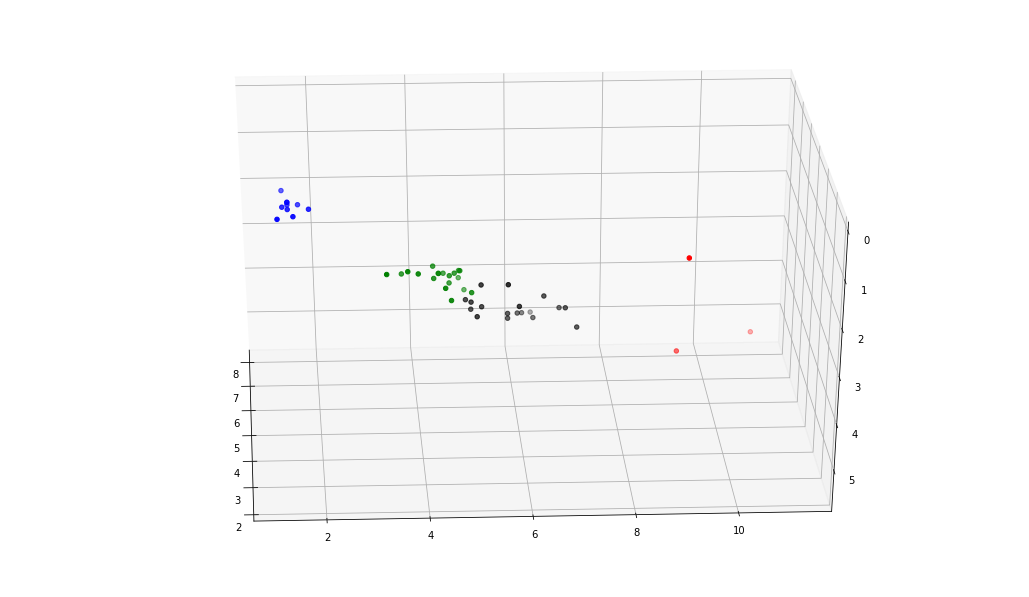

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(14, 8))
# create 3d axis object to use and set rotation for good view
ax = Axes3D(fig, elev=-150, azim=3)
ax.scatter(outliers['1'], outliers['2'], outliers['3'], c='r')
# map label numbers to color values
colors = yts[yts.index.isin(inliers.index)].map({0:'b', 1:'g', 2:'k'})
ax.scatter(inliers['1'], inliers['2'], inliers['3'], c=colors);